In [10]:
import numpy as np
import os
os.chdir('/home/ia404/gitreps/dustbias/mbatch/')
import argparse
from pytempura import norm_lens
from utils import get_auto_name, bandedcls, get_dust_name, get_norm_name, get_noise_dict_name
from orphics import stats
from falafel import utils as futils
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

path = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/mbatch_lmin/stage_auto/'
data_path = lambda x: os.path.join(path, x)

%matplotlib inline

In [2]:
Tcmb  = 2.7255e6
def read_camb_cls(fname,ftype='scal',output='',skiprows=1,unpack=True):
    
    if ftype == 'scal': # unlensed scal Cls
        ll, TT, EE, TE, PP, TP = np.loadtxt(fname,skiprows=skiprows,unpack=unpack)
    
    elif ftype == 'lens': # lensed cls
        ll, TT, EE, BB, TE = np.loadtxt(fname,skiprows=skiprows,unpack=unpack)

    s = ll*(ll+1.)*Tcmb**2/(2*np.pi)
    TT /= s
    EE /= s
    TE /= s
    if ftype == 'scal':
        PP /= ll**4*Tcmb**2
        TP /= ll**3*Tcmb**2
    elif ftype == 'lens':
        BB /= s

    TT = np.insert(TT,0,np.array([0.,0.]))
    EE = np.insert(EE,0,np.array([0.,0.]))
    TE = np.insert(TE,0,np.array([0.,0.]))
    if ftype == 'scal':
        PP = np.insert(PP,0,np.array([0.,0.]))
        TP = np.insert(TP,0,np.array([0.,0.]))
    elif ftype == 'lens':
        BB = np.insert(BB,0,np.array([0.,0.]))

    if ftype == 'scal':
        if output=='array':
            return np.array((TT,EE,TE,PP,TP))
        else:
            return TT, EE, TE, PP, TP
    elif ftype == 'lens':
        if output=='array':
            return np.array((TT,EE,BB,TE))
        else:
            return TT, EE, BB, TE

In [3]:
args = argparse.Namespace()

In [4]:
args.filter_whiteamplitude = 12.
args.filter_whitefwhm = 1.4
args.lmax = 3000
args.mlmax = 4000
args.est = 'TT'
args.dust_freq = 95.
args.mask_subproduct = 'lensing_masks'
args.mask_type = 'wide_v4_20220316'
args.apodfact = '3dg'
args.config_name = 'act_dr6v4'

In [5]:
ell_arr = np.arange(args.mlmax+1)
lfac =  (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)
lfac_2pt = ell_arr * (ell_arr + 1)
lcut = 500
nbands = 100
lbands = np.concatenate((np.linspace(2, lcut)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands+1)))#  dtype=int)

In [6]:
FG_TYPES = ['pysm_d1', 'pysm_d6', 'pysm_d10', 'dust_DF', 'dust_van']
GALS = ['GAL040', 'GAL060', 'GAL070']
LMINS = [10, 200, 600]
LMAXS = [3000, 3500]

In [7]:
args.lmin = 600 
args.dust_type = FG_TYPES[0]
args.skyfrac = GALS[-1]
oname = get_dust_name(args)
cl_2pt = np.load(data_path(f'cl_{oname}.npy'))[0] / Tcmb**2 # TEMPERATURE

In [8]:
Als = np.load(data_path(f'../stage_filter/{get_norm_name(args)}'), allow_pickle=True).item()
noise = np.load(data_path(f'../stage_filter/{get_noise_dict_name(args)}'), allow_pickle=True).item()

In [9]:
noise['TT']

array([1.21846968e-05, 1.21846974e-05, 1.10793502e+03, ...,
       2.91500020e-05, 2.91578044e-05, 2.91656177e-05])

In [11]:
ucls, tcls = futils.get_theory_dicts(nells=None, lmax=args.mlmax, grad=True)
theory_2pt = read_camb_cls('./data/lensedcls.dat',ftype='lens',output='array')[0, :args.mlmax+1] # [:,:rlmax+1]

In [13]:
ucls

{'TT': array([0.00000000e+00, 0.00000000e+00, 1.10088451e+03, ...,
        1.09918109e-06, 1.09608280e-06, 1.09298650e-06]),
 'TE': array([ 0.00000000e+00,  0.00000000e+00,  3.08294455e+00, ...,
        -5.30381518e-08, -5.28244432e-08, -5.26113883e-08]),
 'EE': array([0.00000000e+00, 0.00000000e+00, 4.03967413e-02, ...,
        3.59933906e-08, 3.58855084e-08, 3.57781780e-08]),
 'BB': array([0.00000000e+00, 0.00000000e+00, 3.24007740e-06, ...,
        1.18282192e-09, 1.18092827e-09, 1.17903802e-09]),
 'kk': array([0.00000000e+00, 0.00000000e+00, 8.18243515e-08, ...,
        9.53190627e-10, 9.52672264e-10, 9.52169609e-10])}

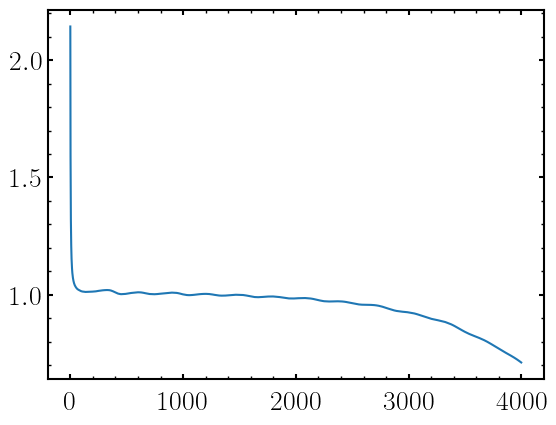

In [18]:
plt.plot(ucls['TT'][2:]/(theory_2pt[2:]*Tcmb**2))

In [28]:
# Ag, Ac = norm_lens.qtt(lmax = args.mlmax, rlmin=args.lmin, rlmax = args.lmax, TT = theory_2pt, fTT = cl_2pt, OCT=cl_2pt)
Ag, Ac = norm_lens.qtt(lmax = args.mlmax, rlmin=args.lmin, rlmax = args.lmax, TT = theory_2pt, fTT = noise['TT'], OCT=cl_2pt)

In [29]:
Ag /= Als['TT'][0]
Ac /= Als['TT'][1]

/tmp/ipykernel_971595/1226424239.py:1: RuntimeWarning: invalid value encountered in divide
  Ag /= Als['TT'][0]
/tmp/ipykernel_971595/1226424239.py:2: RuntimeWarning: invalid value encountered in divide
  Ac /= Als['TT'][1]


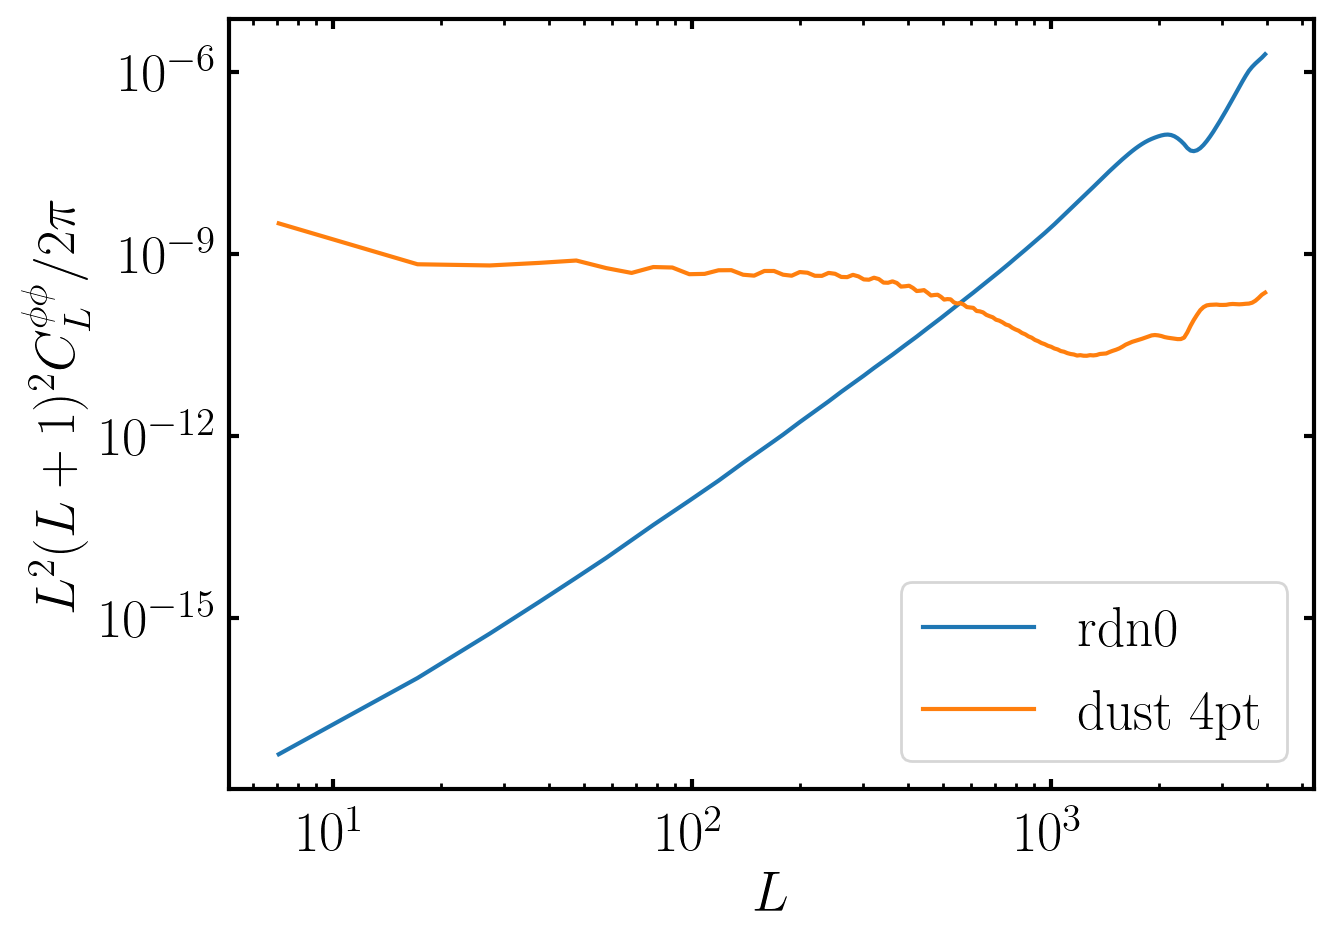

In [30]:
oname = get_auto_name(args)
cl_4pt = np.loadtxt(data_path(oname))

fig, ax = plt.subplots(1, 1, figsize=(7,5), dpi = 200)
cl = np.loadtxt(data_path(oname))

bin_ell, bin_cell = bandedcls(cl * lfac, lbands)
bin_ell_rdn0, bin_cell_rdn0 = bandedcls(Ag * lfac, lbands)
ax.loglog(bin_ell_rdn0, bin_cell_rdn0, label = 'rdn0')
ax.loglog(bin_ell, bin_cell, label = 'dust 4pt') # , linewidth = 2, linestyle = dict_plot[fsky]['linestyle'], color = dict_plot[dust_types]['color'])
ax.legend()
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')
fig.savefig('./Figures/rdn0_dust_4pt_test4.png', bbox_inches = 'tight')
plt.show()
